#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

## 0. 데이터 불러오기

In [2]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]

year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')
college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())

# 상권 점포 데이터 
store_inf = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권점포-통합).csv', low_memory=False)

### 해당 상권의 총 점포수 확인(프랜차이즈 점포수까지 확인)
store_inf['총_점포_수'] = store_inf['점포_수'] + store_inf['프랜차이즈_점포_수']

year_month = []
for i in range(store_inf.shape[0]):
    year_month.append(str(store_inf['기준_년_코드'].iloc[i]) + '-' + str(store_inf['기준_분기_코드'].iloc[i]))

store_inf['년-분기'] = year_month

## 1. 데이터 전처리(고정) 

- [1] 추정매출 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [2] 상권점포 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [3] 상권점포 데이터 中 특정 분기에만 등장하는 상권 제거: 48개의 상권(2020-4분기)
- [4] 상권점포 데이터에서 각 상권별 서비스 업종 추출(22개 분기 모두 등장하는 업종만 추출)

In [3]:
# (1) 추정매출 데이터 내 오탈자 변경
buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (2) 상권 점포 데이터 내 오탈자 변경
store_inf['상권_코드_명'] = store_inf['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (3) 상권 개수 맞춰서 진행하기
store_point_list = list(store_inf[store_inf['년-분기'] == "2016-1"]['상권_코드_명'].unique())
store_inf = store_inf.query('상권_코드_명 in @ store_point_list')

In [4]:
#(4) 상권별 - 서비스 업종이 22개 등장하는 업종만 뽑기 
find_value = (store_inf.groupby(['상권_코드','서비스_업종_코드_명'])[['기준_년_코드','기준_분기_코드']].count() == 22).reset_index()
find_value = find_value[(find_value['기준_년_코드'] == True)]

#### 22분기에 등장하는 상권-서비스 업종 대응 list
commercial_code = []
service_type_code = []
for i in find_value['상권_코드'].unique():
    commercial_code.append(i)
    value_list = []
    find_value_part = find_value[find_value['상권_코드'] == i]
    for j in find_value_part['서비스_업종_코드_명'].unique():
        value_list.append(j)
        value_list = list(set(value_list))
    service_type_code.append(value_list)
    
#### 각 상권코드를 가지고 와서 query문으로 데이터 정제
selected_data = []
for num,i in enumerate(commercial_code):  
    price_df_1 = store_inf[store_inf['상권_코드'] == i]
    find_servicetype_list = service_type_code[num]
    
    price_df_2 = price_df_1.query('서비스_업종_코드_명 in @ find_servicetype_list')    
    # 상권코드와 조합되는 서비스 업종 코드명으로 데이터 정제 후 저장
    
    selected_data.append(price_df_2)
    
data_cm = pd.concat(selected_data)
#data_cm.to_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')

store_inf = data_cm
store_inf = store_inf.reset_index(drop = True)

In [5]:
'''store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')
store_inf = store_inf.reset_indexd(drop = True)'''

"store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')\nstore_inf = store_inf.reset_indexd(drop = True)"

## 2. 데이터 Clustering 

### (1) clustring 전처리 (scatter plot도 동시에 진행)

- 업종 소분류를 상위 개념끼리 묶음화(중분류 만들기) 후 '기타'항목 제거
   
   - 음식점류 : '한식음식점','양식음식점','분식전문점','중식음식점','치킨전문점','일식음식점', '패스트푸드점'
   - 디저트류: '커피-음료' ,'제과점'
   - 소매점류: '슈퍼마켓','편의점',
   - 주점류: '호프-간이주점'
   - 오락류: '당구장','노래방','PC방'
   - 미용뷰티류: '미용실','네일숍','화장품','피부관리실'
   - 기타류: 위의 것들은 제외한 모든 소분류
     
     
- 각 상권별 평균 점포수가 특정 값(thresholo) 낮으면 해당 상권 제거: 3 기준(변경 가능한 점)

In [6]:
# (1) clustring 전처리 - 추정매출 중분류 개념 생성

print("buy_data에 서비스 업종 종류: \n{}".format(list(buy_data.서비스_업종_코드_명.unique()))) # buy_data의 서비스 업종 확인

# 중분류 정의
food_type = ['한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점']
desert_type = ['커피-음료' ,'제과점']
market_type = ['슈퍼마켓','편의점']
drunk_type = ['호프-간이주점'] 
game_type = ['당구장','노래방','PC방','골프연습장']
bueaty_type = ['미용실','네일숍','화장품','피부관리실']

# 
buy_data['서비스_업종_중분류'] = buy_data['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')

# 기타 중분류는 분류에서 제외
data = buy_data[buy_data['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 대학상권만 가져오기
machul = data[data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

buy_data에 서비스 업종 종류: 
['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원', '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '여관', '스포츠클럽', '세탁소', '당구장', '서적', '호프-간이주점', '반찬가게', '컴퓨터및주변장치판매', '시계및귀금속', '전자상거래업', '일식음식점', '치과의원', '치킨전문점', '의약품', '화초', '문구', '화장품', '핸드폰', '예술학원', '네일숍', '가구', '육류판매', '안경', '노래방', '외국어학원', '미곡판매', '자동차수리', '일반의원', '일반교습학원', '피부관리실', '조명용품', '의료기기', '인테리어', '가전제품', 'PC방', '애완동물', '스포츠 강습', '철물점', '청과상', '운동/경기용품', '섬유제품', '자동차미용', '신발', '골프연습장', '자전거 및 기타운송장비', '수산물판매', '가전제품수리', '완구', '부동산중개업', '고시원']


In [7]:
# (2) 상권별 평균 점포수 확인
check = machul.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포수', aggfunc = 'sum', 
                           fill_value = 0).sort_values(by = '2016-1')
check['평균_점포수'] = check.mean(axis = 1).round(2)

# 점포수가 적어 제거될 상권
except_cm = list(check.query('평균_점포수 <1').index)
print("점포수가 적어 제거될 상권: {}".format(except_cm))

# 해당 상권 제거
final_data = machul.query('상권_코드_명 != @except_cm').reset_index(drop=True)

print("최종 사용할 상권 수: {}개".format(len(machul['상권_코드_명'].unique())))

점포수가 적어 제거될 상권: []
최종 사용할 상권 수: 315개


#### 상권 점포 전처리
- 싱권 점포에서 추정매출과의 데이터 동일성을 위해 동일한 전처리 진행 > (1) 
- 대학 상권 vs 서울 상권의 (코로나 기간: 2020년 이후) 개/폐업률 평균 비교

In [8]:
# 각 상권마다 중분류에서 기타를 제외한 부분을 추출
store_inf['서비스_업종_중분류'] =  store_inf['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')
reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 상권점포-통합 데이터의 대학상권 추출
college_store_inf = reduce_store_inf .query('상권_코드_명 in @ college_cm_name')

# 추정매출간 점포수가 적었던 상권 제외 
college_store_inf = college_store_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True)

display(store_inf.서비스_업종_중분류.unique())

array(['기타', '주점류', '음식점류', '디저트류', '미용뷰티류', '오락류', '마켓류'], dtype=object)

In [9]:
# 대학상권 분기별 개/폐업률 확인
college_store_cnt = college_store_inf.groupby('년-분기')['총_점포_수'].sum()         # 분기별 대학상권 점포수
college_openstore_cnt = college_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 대학상권 개업 점포 수
college_closestore_cnt = college_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 대학상권 폐업 점포 수

openstore_ratio_byquan = college_openstore_cnt / college_store_cnt * 100   # 분기별 대학상권 개업률
closestore_ratio_byquan = college_closestore_cnt / college_store_cnt  * 100 # 분기별 대학상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid = np.round(openstore_ratio_byquan.iloc[-6:].mean(), 3)  
close_point_aftercovid = np.round(closestore_ratio_byquan.iloc[-6:].mean(), 3)

display('대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid))
display('대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid))

'대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : 3.075'

'대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : 3.335'

In [10]:
# 서울상권 분기별 개/폐업률 확인
store_cnt = reduce_store_inf.groupby('년-분기')['총_점포_수'].sum()        # 분기별 서울상권 점포수
openstore_cnt = reduce_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 서울상권 개업 점포 수
closestore_cnt = reduce_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 서울상권 폐업 점포 수

openstore_ratio_byquan_seoul = openstore_cnt / store_cnt * 100   # 분기별 서울상권 개업률
closestore_ratio_byquan_seoul = closestore_cnt / store_cnt * 100 # 분기별 서울상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid_seoul = np.round(openstore_ratio_byquan_seoul.iloc[-6:].mean(), 3)  
close_point_aftercovid_seoul = np.round(closestore_ratio_byquan_seoul.iloc[-6:].mean(), 3)

display('서울상권의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid_seoul))
display('서울상권의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid_seoul))

'서울상권의 (코로나 이후) 평균 개업률 : 3.368'

'서울상권의 (코로나 이후) 평균 폐업률 : 3.409'

#### clustring 

In [11]:
# 상권별 분기 매출금액
df = final_data.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_총매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

part_01_01 = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose()

# Task 1. 예년(2016 ~ 2018년도) 증감 평균(기하 평균)

## 1.1 17년, 18년도(작년 대비) 증가율 

result_list = []
columne_name = []
index_name = list(part_01_01.index)

for num, year in enumerate([2017, 2018]):
    num = num * 4 
    
    for i in range(0,4,1):
        value = num + i                           # index 맞추기
        quarter = i + 1                           # 분기

        point = part_01_01.iloc[:,value]          # 이전 년도 분기
        comparison = part_01_01.iloc[:,value + 4] # 비교 년도 분기 
        
        quarterly_change = comparison.T.div(point).round(4) # (비교 년도 분기 / 이전 년도 분기)
        result_list.append(quarterly_change)                # 값 추가하기 
        
        name = str(year) + '년도' + str(quarter) + '분기 증가율'  
        columne_name.append(name)
        
result_year_ofrat = pd.concat(result_list,axis = 1)       
result_year_ofrat.columns = columne_name

## 1.2 2개년도 증가율에 대한 평균(기하 평균)
result_avg = []
result_column_name = []
for j in range(0,4,1):
    geo_mean_01 = result_year_ofrat.iloc[:,j]
    geo_mean_02 = result_year_ofrat.iloc[:,j + 4]
    final_geo_mean = np.sqrt(geo_mean_01 * geo_mean_02)    # 17년 (분기별) 증가율 * 18년 (분기별) 증가율의 기하 평균
    result_avg.append(final_geo_mean)
    
    result_column = '{}분기 예년 증감 평균'.format(str(j+1))
    result_column_name.append(result_column)
    
result_before_covid = pd.concat(result_avg, axis = 1)
result_before_covid.columns = result_column_name
result_before_covid = result_before_covid.round(4)

# Task 2. 2018년도 대비 2020년도 상권별 매출액 증감(2년치 증가율이기 때문에 root 계산)
column_name2018 = [i for i in list(df['년-분기'].unique()) if '2018' in i]
column_name2020 = [i for i in list(df['년-분기'].unique()) if '2020' in i]
column = column_name2018 +column_name2020

covid_chenge_rate_spread = []
sales_inf_time = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose().loc[:,column]

for i in range(0,4,1):
    bef_point = sales_inf_time.T.iloc[i,:]        # 2018 년도 매출액
    aft_point = sales_inf_time.T.iloc[i + 4,:]    # 2020 년도 매출액
    result_covid = np.sqrt(aft_point.T.div(bef_point)).round(4) # root calcuation
    covid_chenge_rate_spread.append(result_covid)
    
result_after_covid = pd.concat(covid_chenge_rate_spread, axis = 1)
result_after_covid.columns = ['2020년 1분기 증가', '2020년 2분기 증가', '2020년 3분기 증가', '2020년 4분기 증가']

# Task3. feature로 사용할 코로나 영향도

influence_of_covid_list = []

for i in range(0,4,1):
    before_point = result_before_covid.iloc[:,i]    # 예년 평균 증감
    after_point = result_after_covid.iloc[:, i]     # 코로나 이후 증감
    influence_of_covid = after_point - before_point
    influence_of_covid_list.append(influence_of_covid)
    
feature_01 = pd.concat(influence_of_covid_list, axis = 1)
feature_01.columns = ['1분기 covid 영향력','2분기 covid 영향력','3분기 covid 영향력','4분기 covid 영향력']

In [12]:
# feature 2 상권별 평균 점포 수
feature_02_01 = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                        values = '총_점포_수', aggfunc = 'sum', fill_value = 0)
feature_02_01['상권_평균_점포수'] = feature_02_01.loc[:,:].mean(axis = 1).round()
feature_02_01 = feature_02_01[['상권_평균_점포수']]
step_01 = feature_02_01.copy()

from sklearn.preprocessing import RobustScaler

step_01.iloc[:,:] = np.log(step_01.iloc[:,:])
# 점포 수에 대한 scaling 진행 
trans = RobustScaler()
feature_02_01_scaling = trans.fit_transform(step_01)

# scaling 데이터프레임화 
feature_02_01_scaling = pd.DataFrame(feature_02_01_scaling).round(4)
feature_02_01_scaling.index = list(feature_02_01.index)
feature_02_01_scaling.columns = ['상권_평균_점포수(scaling)']
feature_02_01_scaling = feature_02_01_scaling.reset_index().rename(columns = {'index' : '상권_코드_명'}).set_index('상권_코드_명')

# 데이터 프레임 합치기
result = pd.merge(feature_01.reset_index(), feature_02_01.reset_index(), on = '상권_코드_명').set_index('상권_코드_명')
result.head(1)

# scaling 데이터 프레임 합치기 
part_scaling = pd.merge(feature_02_01.reset_index(), feature_02_01_scaling.reset_index(), 
                        on = '상권_코드_명')[['상권_코드_명','상권_평균_점포수(scaling)','상권_평균_점포수']]

result_scaling = pd.merge(feature_01.reset_index(), part_scaling, on = '상권_코드_명').set_index('상권_코드_명')

In [35]:
result_scaling.head()

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수
상권_코드_명,,,,,,
가재울로6길,-0.0642,-0.0605,-0.0934,-0.0798,0.1355,76.0
가좌로7길,-0.1146,-0.1867,-0.1446,-0.1822,-0.2520,53.0
갈현로1길,-0.4420,-0.4315,-0.5137,-0.2889,0.1068,74.0
갈현로7길,-0.1092,-0.1342,-0.0741,-0.0507,0.0000,67.0
강남시장_동작,0.2748,-0.0019,-0.0652,-0.2911,-1.9425,11.0


#### clustring

segment
0     23
1     10
2     16
3     10
4      6
      ..
20    29
21     9
22     1
23     3
24    17
Length: 25, dtype: int64

segment
0       48.0
1      162.0
2       27.0
3      539.0
4       11.0
       ...  
20      93.0
21     291.0
22      11.0
23    1072.0
24      65.0
Name: 상권_평균_점포수, Length: 25, dtype: float64

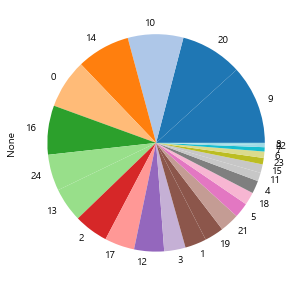

C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


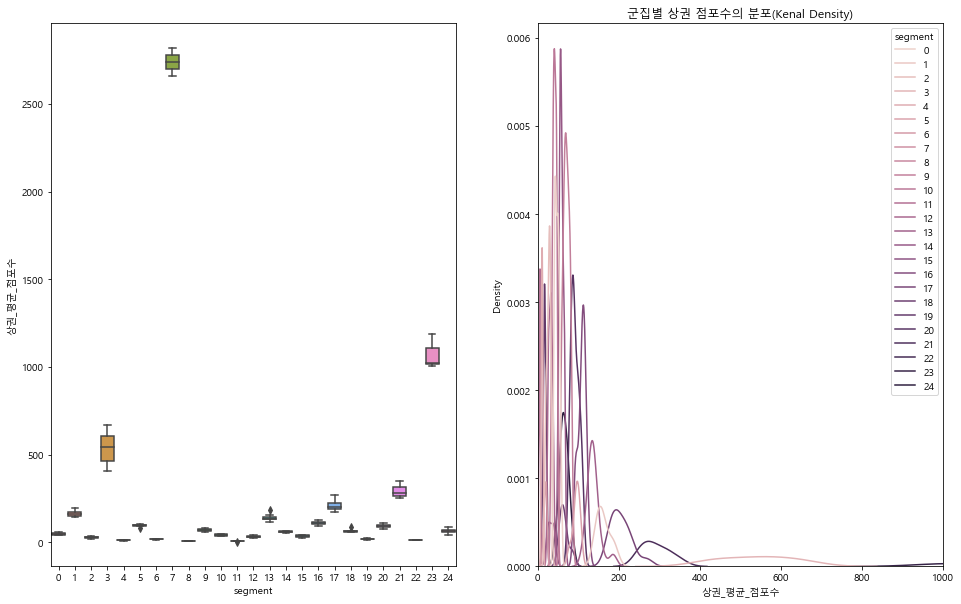

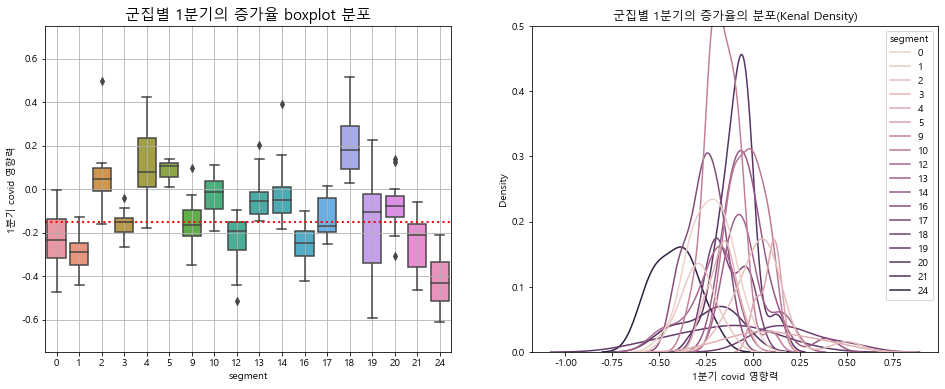

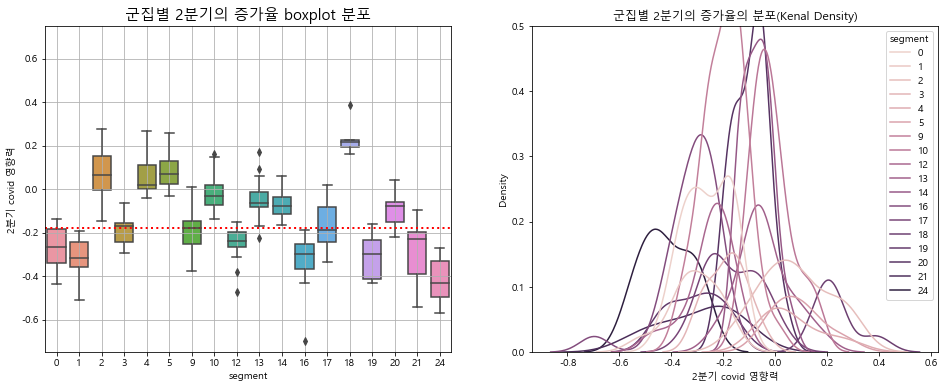

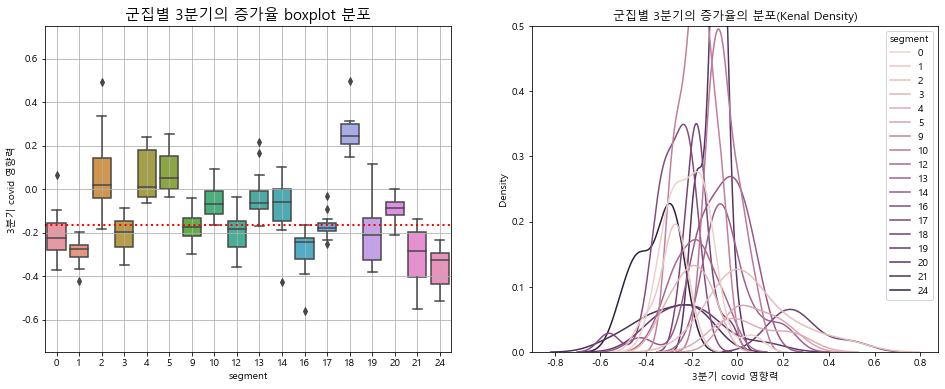

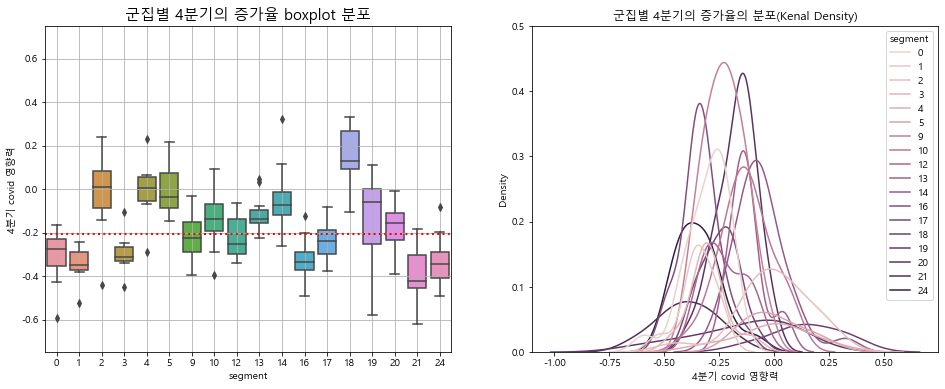

In [13]:
k = 25
for i in [k]:
    result_final = result_scaling .copy()
    inf_covid = feature_01.copy()
    inf_covid = inf_covid.reset_index()
    
    # 0.kmean 적용 후 결과를 저장
    kmeans = KMeans(n_clusters=i, random_state=0).fit(result_final.iloc[:,:-1])
    result_final['segment'] = kmeans.labels_
    
    labels = result_final.value_counts('segment')[result_final.value_counts('segment') >= 5].sort_index().index
    
    ## 군집에 대한 시각화
    
    # 1-1 segment별 분포 확인
    plt.figure(figsize=(16, 10))
    
    display(result_final.value_counts('segment').sort_index())
    display(result_final.groupby('segment')['상권_평균_점포수'].mean().round(0))
    
    # 1-2 파이 그래프로 확인
    result_final.value_counts('segment').plot.pie(cmap=plt.cm.tab20, figsize = (14,5))
    plt.show()
    
    ## 점포수의 시각화
    
    # 2-1 각 군집별 상권 점포 수의 boxplot
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='segment', y='상권_평균_점포수', data = result_final)
    
    # 2-2  각 군집별 상권 점포 수의 밀도(분포)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=result_final, x= "상권_평균_점포수", hue="segment")
    plt.xlim([0,1000])
    plt.title('군집별 상권 점포수의 분포(Kenal Density)')
    
    
    ## 각 군집별 코로나 영향도 확인
    
    for n, col_name in enumerate(['1분기 covid 영향력', '2분기 covid 영향력' ,'3분기 covid 영향력', '4분기 covid 영향력']): 
        col = col_name[:3]
        avg = np.round(feature_01.iloc[:, n].mean(),3)
        
        plt.figure(figsize=(16, 6))

        # 3.1 각 군집별 코로나의 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(x='segment', y= col_name , data = result_final.query('segment in @ labels'))
        plt.title('군집별 {}의 증가율 boxplot 분포'.format( col), size=15)
        plt.ylim([-0.75, 0.75])
        plt.axhline(y = avg, color = 'red', linestyle = ':',linewidth=2)
        
        plt.grid()
        
        # 3.1 각 군집별 코로나의 분포
        plt.subplot(1, 2, 2)
        sns.kdeplot(data = result_final.query('segment in @ labels'), x= col_name, hue="segment")
        plt.title('군집별 {}의 증가율의 분포(Kenal Density)'.format(col))
        plt.ylim([0, 0.5])
        
    plt.show()

In [14]:
result_final.query('segment == 18')

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment
상권_코드_명,,,,,,,
고척근린시장,0.5153,0.3876,0.4954,0.3040,-0.1928,56.0,18
고척로27길,0.1524,0.1859,0.1478,-0.1039,0.0000,67.0,18
대림골목시장,0.0282,0.2168,0.2486,0.1491,-0.1009,61.0,18
아현시장,0.3138,0.2279,0.1988,0.0907,0.2558,85.0,18
왕십리로14길,0.0727,0.1628,0.3143,0.3303,0.0000,67.0,18
퇴계로18길,0.2107,0.2168,0.2406,0.1060,-0.1738,57.0,18


In [15]:
result_final.reset_index().to_csv('clustring_result.csv', index = False)

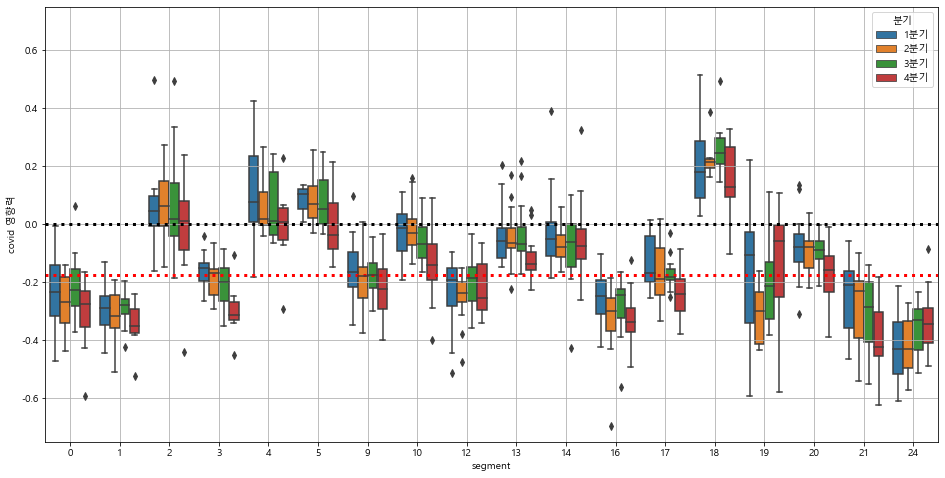

In [16]:
## 원본데이터 Frame
new = feature_01.reset_index()
eda_01 = pd.merge(new, result_final.reset_index()[['상권_코드_명','상권_평균_점포수','segment']], on ='상권_코드_명')

### 분기 분할
qur_01_inpact = eda_01[['상권_코드_명','1분기 covid 영향력','segment']].rename(columns = {'1분기 covid 영향력': 'covid 영향력'})
qur_02_inpact = eda_01[['상권_코드_명','2분기 covid 영향력','segment']].rename(columns = {'2분기 covid 영향력': 'covid 영향력'})
qur_03_inpact = eda_01[['상권_코드_명','3분기 covid 영향력','segment']].rename(columns = {'3분기 covid 영향력': 'covid 영향력'})
qur_04_inpact = eda_01[['상권_코드_명','4분기 covid 영향력','segment']].rename(columns = {'4분기 covid 영향력': 'covid 영향력'})

## 분기 feature 추가 
qur_01_inpact['분기'] = '1분기'
qur_02_inpact['분기'] = '2분기'
qur_03_inpact['분기'] = '3분기'
qur_04_inpact['분기'] = '4분기'

# 데이터 합치기
fact_01 = pd.concat([qur_01_inpact, qur_02_inpact, qur_03_inpact, qur_04_inpact], axis =0).reset_index().iloc[:,1:]
fact_01 = fact_01.sort_values(by = ['상권_코드_명','분기']).reset_index().iloc[:,1:]
fact_01.head(10)

fig, ax = plt.subplots(figsize = (16,8))

# order = order = [i for i in range(0, k, 1)]
total_avg = round(fact_01['covid 영향력'].mean(),4)

sns.boxplot(x = "segment", y = "covid 영향력", hue = "분기", data = fact_01.query('segment in @labels'), ax = ax)
plt.axhline(y = 0, color = 'black', linestyle = ':',linewidth = 3)
plt.axhline(y = total_avg, color = 'red', linestyle = ':',linewidth = 3)
plt.ylim([-0.75, 0.75])

plt.grid()
plt.show()

## 회복 탄력성 만들기(중요)

- 목적: 각 상권마다 회복 탄력성을 만들어서, 코로나 19가 지난 시저에서 어느 정도 회복했는지 확인
(회복 탄력성이 높은 곳 vs 낮은 곳의 통계치 비교)

- 사용 내용: 예년 증감율 (2016~2018 1, 2분기) vs 코로나 확산기(2020년 1,2분기) vs 코로나 안정기(2021년 1,2분기) 구분

#### 

In [87]:
# EDA 그리기(회복 탄력성)

# Task 1. 2018, 20, 21년에 대한 각 매출액 값 가져오기(1,2분기 평균)
column_2018 = [i for i in list(df['년-분기'].unique()) if '2018' in i][:2]
column_2020 = [i for i in list(df['년-분기'].unique()) if '2020' in i][:2]
column_2021 = [i for i in list(df['년-분기'].unique()) if '2021' in i]
column_total = column_2018 + column_2020 + column_2021

point_data = part_01_01.loc[:,column_total]

comparison_value = [] 
for year in [column_2018, column_2020, column_2021]:
    value_part = point_data.loc[:,year].mean(axis = 1)
    comparison_value.append(value_part)
    
comparison_sales = pd.concat(comparison_value, axis = 1)
comparison_sales.columns = ['매출액(이전)','매출액(확산기)', '매출액(안정기)']

# Task2. 기울기 (#1: (20년도 - 18년도) / 18년도,  #2: (21년도 - 20년도) / 18년도 

## 코로나 확산기에 대한 변화율
tilt01_list = []

for tilt01 in range(2):
    tilt01_point = point_data.iloc[:, tilt01]
    tilt01_after = point_data.iloc[:, tilt01 + 2] 
    tilt01_value = tilt01_after.sub(tilt01_point).div(tilt01_point) # (20년 - 18년) / 18년
    tilt01_list.append(tilt01_value)

tilt01 = pd.concat(tilt01_list, axis = 1)
tilt01.columns = ['1분기_매출액변화율(확산기)','2분기_매출액변화율(확산기)']
tilt01_avg = tilt01.mean(axis = 1).round(4)
tilt01_avg = tilt01_avg.reset_index().rename(columns = {0 : '매출액_변화율(확산기)'})

## 코로나 안정기에 대한 변화율
tilt02_list = []
for tilt02 in range(2):
    tilt02_denom = point_data.iloc[:, tilt02]     # 분모(18년도 분기)
    tilt02_point = point_data.iloc[:, tilt02 + 2] # 분자(20년도 분기)
    tilt02_after = point_data.iloc[:, tilt02 + 4] # 분자(21년도 분기)
     
    tilt02_value = tilt02_after.sub(tilt02_point).div(tilt02_denom) # (21년 - 20년) / 18년
    tilt02_list.append(tilt02_value)

    
tilt02 = pd.concat(tilt02_list, axis = 1)
tilt02.columns = ['1분기_매출액변화율(안정기)','2분기_매출액변화율(안정기)']
tilt02_avg = tilt02.mean(axis = 1).round(4)
tilt02_avg = tilt02_avg.reset_index().rename(columns = {0 : '매출액_변화율(안정기)'})

value = pd.merge(tilt01_avg, tilt02_avg, on = '상권_코드_명')

# 최종 data
final_value = pd.merge(comparison_sales.reset_index(), value, on = '상권_코드_명').set_index('상권_코드_명')

In [61]:
final_value.reset_index().query('상권_코드_명 == "응암로14길"')

,상권_코드_명,매출액(이전),매출액(확산기),매출액(안정기),매출액_변화율(확산기),매출액_변화율(안정기)
225,응암로14길,1.457090e+09,928926804.0,1.370552e+09,-0.3376,0.318


#### sample(5개) 상권 탄력성 확인

- 회복탄력성을 보기 위해서 매출액의 위치 좌표(전체적인 상권의 크기가 달라 scaling 진행: 시각화에서만)

In [147]:
def individual_find(street):
    # 개별 상권 가져오기 
    part = final_value.reset_index()
    individual_cm = part[part['상권_코드_명'] == street]
    individual_cm = individual_cm.set_index('상권_코드_명')
    
    total_sale = individual_cm.iloc[:, :3]
    begin = total_sale['매출액(이전)']
    
    recovery_data = total_sale.T.div(begin.values).sub(1).round(2).mul(100).T 
    
    fig, ax = plt.subplots(figsize = (20,8))
    recovery_data.T.plot(ax = ax, title = '{} 회복 탄력성 EDA'.format(street))
    
    #plt.legend(bbox_to_anchor = (1.0,1.0))
    
    #for pos in range(individual_cm.iloc[0, 3:].shape[0]):
    #    plt.text(pos + 1 , recovery_data.iloc[:, pos + 1] * 0.9, individual_cm.iloc[0, pos + 3], fontsize=15)
        
def sampling_find(seed, num): 
    
    # 데이터 정리 
    total_sale = final_value.iloc[:, :3] # 매출 데이터 가져오기
    begin = total_sale['매출액(이전)']   # 매출 데이터 中 코로나 이전 매출액(2018년 1,2분기 평균)을 기준
    
    recovery_data = total_sale.T.div(begin.values).sub(1).round(2).mul(100).T # 코로나 이전 매출액 대비해서 증가율 확인
    
    # 시각화
    recovery_data.sample(num).T.plot(figsize = (20,10), title = 'smapling {}개의 회복 탄력성 확인'.format(num))
    plt.legend(bbox_to_anchor = (1.0,1.0))

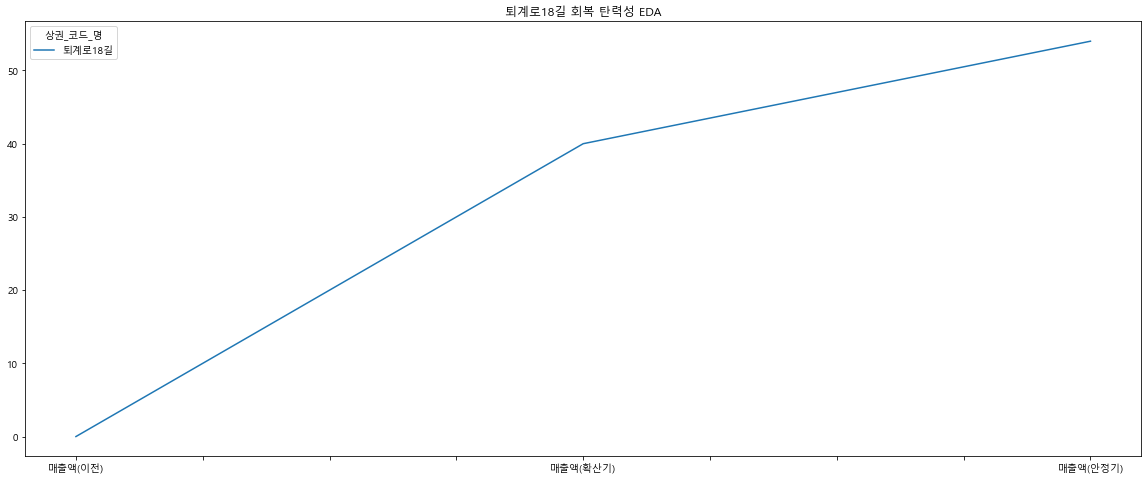

In [156]:
individual_find('퇴계로18길')

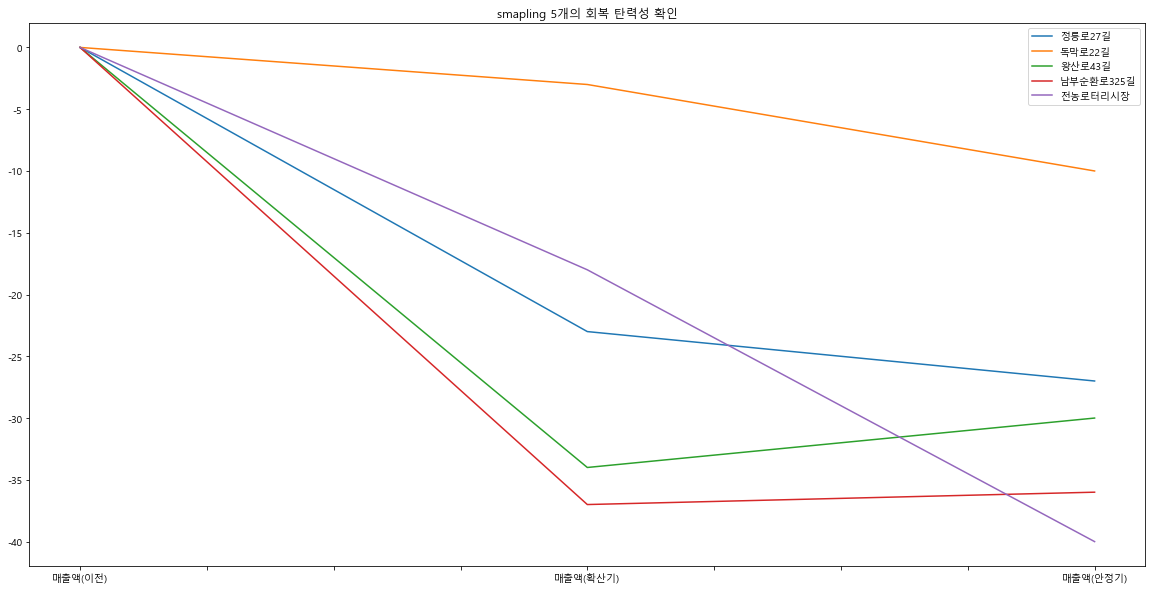

In [152]:
sampling_find(0,5)

#### sample 상권확인하기(순수 매출액)

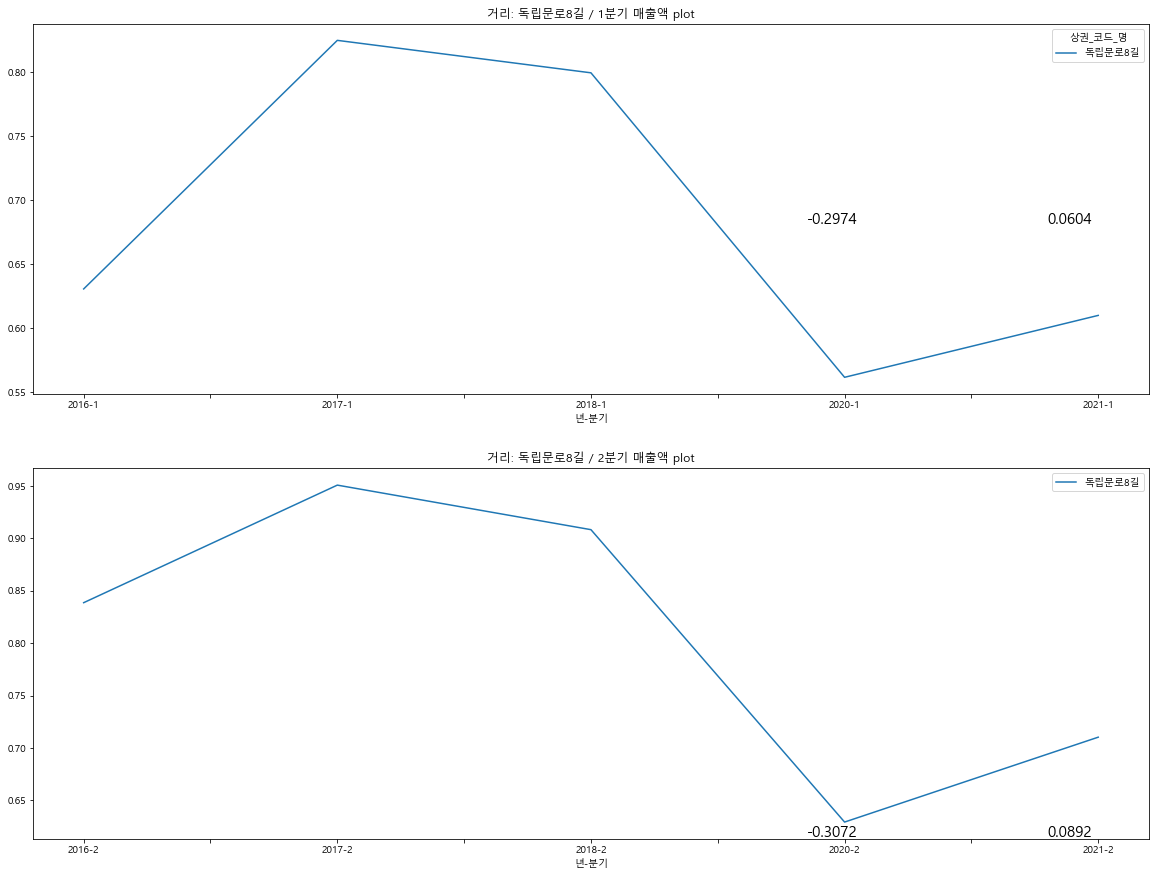

년-분기,2016-1,2016-2,2017-1,2017-2,2018-1,2018-2,2020-1,2020-2,2021-1,2021-2
상권_코드_명,,,,,,,,,,
독립문로8길,630864028.0,838673747.0,824982257.0,950884585.0,799634215.0,908366734.0,561857707.0,629290529.0,610195160.0,710307119.0


In [145]:
# 분기별 증가추세 확인(1,2분기) : 따로 확인하는 것은 분기별 scaling은 다르지만 전반적인 추세는 비슷
def change_of_rate_plot(street):
    a = final_data[final_data['상권_코드_명'] == street].query('기준_분기_코드 == 1 or 기준_분기_코드 == 2') # 특정 상권 추출

    quarter_col_12 = [i for i in list(a['년-분기'].unique()) if '2019' not in i][:-2] + ['2021-1','2021-2']  # colume명 추출
    quarter_01_col = [i for i in quarter_col_12 if '-1' in i]  # 1분기 columne 명 가져오기
    quarter_02_col = [i for i in quarter_col_12 if '-2' in i]  # 2분기 columne 명 가져오기
    
    # 1분기 2분기 데이터만 나눠서 시각화(년도별)
    quarter_first = a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                  values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_01_col]
    quarter_second = a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                  values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_02_col]
    
    # 각 분기별 변화율 표시 
    quarter_first_change = pd.concat(tilt01_list, axis = 1).round(4)
    quarter_first_change.columns = ['매출액_변화율(1분기/확산기)', '매출액_변화율(2분기/확산기)']
    
    quarter_second_change = pd.concat(tilt02_list, axis = 1).round(4)
    quarter_second_change.columns = ['매출액_변화율(1분기/안전기)', '매출액_변화율(2분기/안전기)']
    
    change_data = pd.merge(quarter_first_change.reset_index(), 
                           quarter_second_change.reset_index(), on = '상권_코드_명')
    change_data = change_data[change_data['상권_코드_명'] == street].set_index('상권_코드_명')
    
    change_data = change_data[['매출액_변화율(1분기/확산기)','매출액_변화율(1분기/안전기)',
                               '매출액_변화율(2분기/확산기)','매출액_변화율(2분기/안전기)']]

    # plot 그리기(각 분기별 추세 확인)
    fig, ax = plt.subplots(2, 1, figsize = (20,15))

    quarter_first.iloc[:, :].T.div(1e9).plot(ax = ax[0], title = '거리: {} / 1분기 매출액 plot'.format(street))
    for pos in range(2):
        x_value = (3 + pos) * 0.95
        if  (abs(quarter_first.iloc[:, pos + 3]) / 1e9).round(5)[0] <=1 : 
            y_value = 1.2
        else:
            y_value = (abs(quarter_first.iloc[:, pos + 3]) / 1e9).round(5) + 0.75
            
        plt.text(x_value, y_value, change_data.iloc[0, pos], fontsize=15)

    quarter_second.iloc[:, :].T.div(1e9).plot(ax = ax[1], title = '거리: {} / 2분기 매출액 plot'.format(street))
    ax[1].legend(bbox_to_anchor = (1.0,1.0))
    for pos in range(2):
        x_value =(3 + pos) * 0.95
        if  (abs(quarter_second.iloc[:, pos + 3]) / 1e9).round(5)[0] <=1 : 
            y_value = 0.6 + 0.015
        else:
            y_value = (abs(quarter_second.iloc[:, pos + 3]) / 1e9).round(5) + 0.015
            
        plt.text(x_value, y_value, change_data.iloc[0, pos+2], fontsize=15)
        
    plt.show()
    display(a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                          values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_col_12])
    
change_of_rate_plot('독립문로8길')

#### 사분할 그리기 

- 예시 : https://rfriend.tistory.com/415
- 의미 있는 분할을 위해서 size를 다양하게 시도

In [128]:
# 반올림하기 
tilt01 = tilt01.round(4)
tilt02 = tilt02.round(4)

cf_past = result_before_covid[['1분기 예년 증감 평균','2분기 예년 증감 평균']].agg(lambda x: (x-1))

# 기존 상권의 추세 제거하기(확산기 매출액 변화율 - 예년 평균 변화율)
spread_list = []
stabilize_list = []

for quarter in range(2):
    past_point = cf_past.iloc[:, quarter]
    spread_value = tilt01.iloc[:, quarter]
    stability_value = tilt02.iloc[:, quarter]
    
    v1 = spread_value - past_point    # 확산기 매출액 변화율 - 예년 평균 변화율 (분기별)
    v2 = stability_value - past_point # 안정기 매출액 변화율 - 예년 평균 변화율 (분기별)
    
    spread_list.append(v1)
    stabilize_list.append(v2)
    
spread_avg = pd.concat(spread_list, axis = 1).mean(axis= 1).round(4).reset_index()
stabilize_avg = pd.concat(stabilize_list, axis = 1).mean(axis= 1).round(4).reset_index()

one_step = pd.merge(spread_avg, stabilize_avg, on = '상권_코드_명').set_index('상권_코드_명')
one_step.columns = ['매출액_변화율(확산기/추세제거)','매출액_변화율(안정기/추세제거)']

two_step = pd.merge(comparison_sales.reset_index(), one_step.reset_index(), on = '상권_코드_명').set_index('상권_코드_명')

In [129]:
copy = pd.merge(two_step, result_final.reset_index()[['상권_코드_명','상권_평균_점포수']], on = '상권_코드_명')

#### 상권 분석을 위한 사용 데이터 불러오기

In [164]:
def year_month(data):
    year_month = []
    
    for i in range(data.shape[0]):
        year_month.append(str(data['기준_년_코드'].iloc[i]) + '-' + str(data['기준_분기_코드'].iloc[i]))
    
    data['년-분기'] = year_month

# 생활 인구 데이터
life_pop = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-생활인구).csv', encoding = 'cp949')
life_pop = life_pop.rename(columns = {'기준 년코드': '기준_년_코드'})
life_pop = life_pop.query('기준_년_코드 >= 2016')

# 직장 인구 데이터
work_pop = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-직장인구).csv', encoding = 'cp949')
work_pop = work_pop.rename(columns = {'기준_년월_코드': '기준_년_코드'})
work_pop = work_pop.query('기준_년_코드 >= 2016')

year_month(life_pop)
year_month(work_pop)

#### [1] size = 점포수

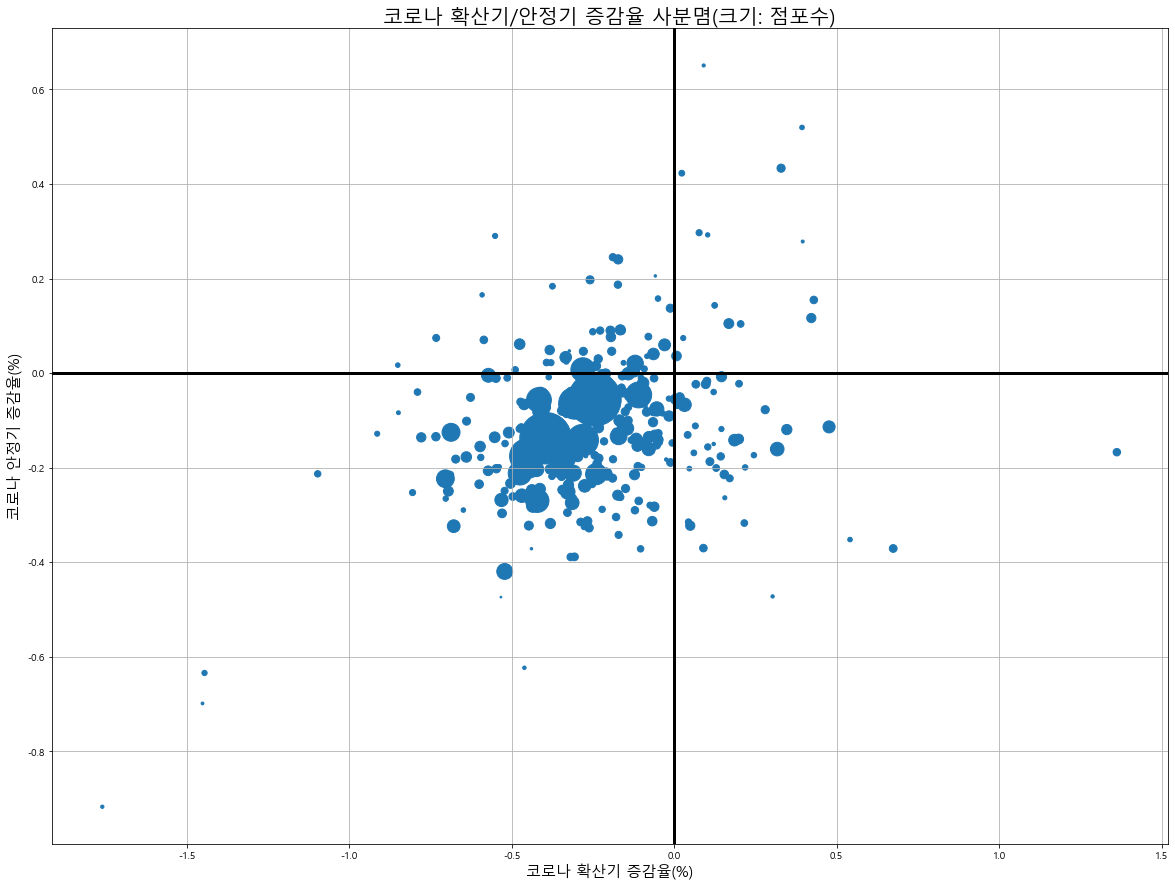

,상권_코드_명,매출액(이전),매출액(확산기),매출액(안정기),매출액_변화율(확산기/추세제거),매출액_변화율(안정기/추세제거),상권_평균_점포수
91,명동 남대문 북창동 다동 무교동 관광특구,2.590790e+11,1.829712e+11,1.564162e+11,-0.2444,-0.0558,2822.0
296,홍익대학교 주변,2.226325e+11,1.343635e+11,1.035539e+11,-0.3954,-0.1377,2657.0
151,서울 서대문구 신촌역,8.748015e+10,4.889131e+10,3.482578e+10,-0.4529,-0.1756,1189.0
92,명동거리,1.206309e+11,7.054154e+10,4.928597e+10,-0.3057,-0.0636,1024.0
240,잠실 관광특구,9.562512e+10,7.885547e+10,7.558111e+10,-0.2813,-0.1420,1004.0


In [136]:
def drawling_scatter(x, y):
    fig, ax = plt.subplots(figsize =(20,15))

    ax.scatter(x,y, cmap='coolwarm', s = copy['상권_평균_점포수'])

    ax.set_xlabel("코로나 확산기 증감율(%)", fontsize=15)
    ax.set_ylabel("코로나 안정기 증감율(%)", fontsize=15)
    ax.set_title('코로나 확산기/안정기 증감율 사분몀(크기: 점포수)', fontsize = 20)
    ax.grid()

    # X,Y 축 고정
    #ax.set_xlim([-3,4])
    #ax.set_ylim([-3,4])

    # x,y축 그리기
    plt.axvline(x = 0, color='black', linewidth=3)
    plt.axhline(y = 0, color='black', linewidth=3)
    # ax.legend(fontsize=12, loc='upper left')

    # 사분면 정의 된거 text 표시
    #plt.text(3.0, 3.0, '순환형', fontsize=25, color='red')
    #plt.text(3.0, -2.5, '성장형', fontsize=25, color='red') 
    #plt.text(-2.0, -2.5, '정체형', fontsize=25, color='red') 
    #plt.text(-2.0, 3.0, '쇠퇴형', fontsize=25, color='red') 

    plt.show()
    
drawling_scatter( copy['매출액_변화율(확산기/추세제거)'],copy['매출액_변화율(안정기/추세제거)'])

copy.sort_values(by = '상권_평균_점포수', ascending = False).head()

#### [2] 점포별 기대 매출액(코로나 이전)

- 매출액과 평균 점포수는 양의 상관관계

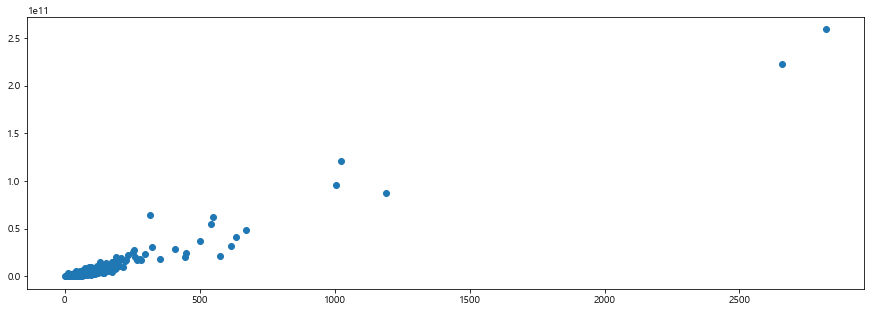

In [161]:
fig, ax = plt.subplots(figsize =(15,5))
    
ax.scatter(x = copy['상권_평균_점포수'], y = copy['매출액(이전)'])

#### [3] 폐업률 or 개업률

- 직장인구와 생활인구의 상관관계 확인
- 

In [168]:
#### 상권별 개/폐업률 계산 (점포수, 개업한 점포수 / 페업한 점포 수)

store_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포_수', \
                                                aggfunc = 'sum',fill_value = 0)

openstore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '개업_점포_수', 
                                                    aggfunc = 'sum',fill_value = 0)

closestore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '폐업_점포_수', \
                                                     aggfunc = 'sum',fill_value = 0)

openstore_ratio_bycma = openstore_cnt_bycma.div(store_cnt_bycma) * 100
closestore_ratio_bycma = closestore_cnt_bycma.div(store_cnt_bycma) * 100

#### 상권별 코로나 이후 평균 개/폐업률
openratio_bycma_aftercovid = np.round(openstore_ratio_bycma.iloc[:, -5:].mean(axis = 1),3)
closeratio_bycma_aftercovid = np.round(closestore_ratio_bycma.iloc[:, -5:].mean(axis = 1),3)

display('상권별 코로니 이후 개업률')
display(openratio_bycma_aftercovid)

display('상권별 코로니 이후 폐업률')
display(closeratio_bycma_aftercovid)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,총_점포_수,년-분기,서비스_업종_중분류
0,2016,1,A,골목상권,1000001,계동길,CS100009,호프-간이주점,1,1,0,0,0,0,0,1,2016-1,주점류
1,2016,1,A,골목상권,1000001,계동길,CS100007,치킨전문점,0,0,0,0,0,0,0,0,2016-1,음식점류
2,2016,1,A,골목상권,1000001,계동길,CS100010,커피-음료,15,17,6,1,0,0,2,17,2016-1,디저트류
3,2016,1,A,골목상권,1000001,계동길,CS100008,분식전문점,5,6,17,1,0,0,1,6,2016-1,음식점류
4,2016,1,A,골목상권,1000001,계동길,CS100002,중식음식점,2,3,0,0,0,0,1,3,2016-1,음식점류
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116529,2021,1,U,관광특구,1001495,잠실 관광특구,CS100005,제과점,19,39,0,0,0,0,20,39,2021-1,디저트류
116530,2021,1,U,관광특구,1001495,잠실 관광특구,CS100004,양식음식점,58,68,3,2,4,3,10,68,2021-1,음식점류
116531,2021,1,U,관광특구,1001495,잠실 관광특구,CS100003,일식음식점,30,37,0,0,0,0,7,37,2021-1,음식점류
116532,2021,1,U,관광특구,1001495,잠실 관광특구,CS100002,중식음식점,20,22,5,1,0,0,2,22,2021-1,음식점류


## 상권 분석(회복 탄력성에 따른)